In [22]:
from keras.applications.convnext import LayerScale
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
import tensorflow as tf
from tensorflow import keras

from data_preparation import prepare_data
from model_preprocessing import convert_image_to_array, model_predict

## Load data

In [2]:
TARGET_HEIGHT = 640
TARGET_WIDTH = 640

In [3]:
X_val, y_val, valid_labels_df, targets = prepare_data()

## Load model

In [4]:
MODEL_NAME = 'pretrain_model_ConvNeXtBase_w_ClssWgt_01-0.3616.h5'
model_path = f'../models/{MODEL_NAME}'
model = tf.keras.models.load_model(model_path, custom_objects={'LayerScale': LayerScale})

In [5]:
model.summary()

Model: "Xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 ImageInput (InputLayer)        [(None, 640, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 convnext_base_stem (Sequential  (None, 160, 160, 12  6528       ['ImageInput[0][0]']             
 )                              8)                                                                
                                                                                                  
 convnext_base_stage_0_block_0_  (None, 160, 160, 12  6400       ['convnext_base_stem[0][0]']     
 depthwise_conv (Conv2D)        8)                                                         

                                                                                                  
 convnext_base_downsampling_blo  (None, 80, 80, 256)  131584     ['tf.__operators__.add_2[0][0]'] 
 ck_0 (Sequential)                                                                                
                                                                                                  
 convnext_base_stage_1_block_0_  (None, 80, 80, 256)  12800      ['convnext_base_downsampling_bloc
 depthwise_conv (Conv2D)                                         k_0[0][0]']                      
                                                                                                  
 convnext_base_stage_1_block_0_  (None, 80, 80, 256)  512        ['convnext_base_stage_1_block_0_d
 layernorm (LayerNormalization)                                  epthwise_conv[0][0]']            
                                                                                                  
 convnext_

 convnext_base_stage_2_block_0_  (None, 40, 40, 512)  25600      ['convnext_base_downsampling_bloc
 depthwise_conv (Conv2D)                                         k_1[0][0]']                      
                                                                                                  
 convnext_base_stage_2_block_0_  (None, 40, 40, 512)  1024       ['convnext_base_stage_2_block_0_d
 layernorm (LayerNormalization)                                  epthwise_conv[0][0]']            
                                                                                                  
 convnext_base_stage_2_block_0_  (None, 40, 40, 2048  1050624    ['convnext_base_stage_2_block_0_l
 pointwise_conv_1 (Dense)       )                                ayernorm[0][0]']                 
                                                                                                  
 convnext_base_stage_2_block_0_  (None, 40, 40, 2048  0          ['convnext_base_stage_2_block_0_p
 gelu (Act

 pointwise_conv_1 (Dense)       )                                ayernorm[0][0]']                 
                                                                                                  
 convnext_base_stage_2_block_3_  (None, 40, 40, 2048  0          ['convnext_base_stage_2_block_3_p
 gelu (Activation)              )                                ointwise_conv_1[0][0]']          
                                                                                                  
 convnext_base_stage_2_block_3_  (None, 40, 40, 512)  1049088    ['convnext_base_stage_2_block_3_g
 pointwise_conv_2 (Dense)                                        elu[0][0]']                      
                                                                                                  
 convnext_base_stage_2_block_3_  (None, 40, 40, 512)  512        ['convnext_base_stage_2_block_3_p
 layer_scale (LayerScale)                                        ointwise_conv_2[0][0]']          
          

 convnext_base_stage_2_block_6_  (None, 40, 40, 512)  512        ['convnext_base_stage_2_block_6_p
 layer_scale (LayerScale)                                        ointwise_conv_2[0][0]']          
                                                                                                  
 convnext_base_stage_2_block_6_  (None, 40, 40, 512)  0          ['convnext_base_stage_2_block_6_l
 identity (Activation)                                           ayer_scale[0][0]']               
                                                                                                  
 tf.__operators__.add_12 (TFOpL  (None, 40, 40, 512)  0          ['tf.__operators__.add_11[0][0]',
 ambda)                                                           'convnext_base_stage_2_block_6_i
                                                                 dentity[0][0]']                  
                                                                                                  
 convnext_

                                                                 dentity[0][0]']                  
                                                                                                  
 convnext_base_stage_2_block_10  (None, 40, 40, 512)  25600      ['tf.__operators__.add_15[0][0]']
 _depthwise_conv (Conv2D)                                                                         
                                                                                                  
 convnext_base_stage_2_block_10  (None, 40, 40, 512)  1024       ['convnext_base_stage_2_block_10_
 _layernorm (LayerNormalization                                  depthwise_conv[0][0]']           
 )                                                                                                
                                                                                                  
 convnext_base_stage_2_block_10  (None, 40, 40, 2048  1050624    ['convnext_base_stage_2_block_10_
 _pointwis

 convnext_base_stage_2_block_13  (None, 40, 40, 512)  1024       ['convnext_base_stage_2_block_13_
 _layernorm (LayerNormalization                                  depthwise_conv[0][0]']           
 )                                                                                                
                                                                                                  
 convnext_base_stage_2_block_13  (None, 40, 40, 2048  1050624    ['convnext_base_stage_2_block_13_
 _pointwise_conv_1 (Dense)      )                                layernorm[0][0]']                
                                                                                                  
 convnext_base_stage_2_block_13  (None, 40, 40, 2048  0          ['convnext_base_stage_2_block_13_
 _gelu (Activation)             )                                pointwise_conv_1[0][0]']         
                                                                                                  
 convnext_

 _pointwise_conv_1 (Dense)      )                                layernorm[0][0]']                
                                                                                                  
 convnext_base_stage_2_block_16  (None, 40, 40, 2048  0          ['convnext_base_stage_2_block_16_
 _gelu (Activation)             )                                pointwise_conv_1[0][0]']         
                                                                                                  
 convnext_base_stage_2_block_16  (None, 40, 40, 512)  1049088    ['convnext_base_stage_2_block_16_
 _pointwise_conv_2 (Dense)                                       gelu[0][0]']                     
                                                                                                  
 convnext_base_stage_2_block_16  (None, 40, 40, 512)  512        ['convnext_base_stage_2_block_16_
 _layer_scale (LayerScale)                                       pointwise_conv_2[0][0]']         
          

 convnext_base_stage_2_block_19  (None, 40, 40, 512)  1049088    ['convnext_base_stage_2_block_19_
 _pointwise_conv_2 (Dense)                                       gelu[0][0]']                     
                                                                                                  
 convnext_base_stage_2_block_19  (None, 40, 40, 512)  512        ['convnext_base_stage_2_block_19_
 _layer_scale (LayerScale)                                       pointwise_conv_2[0][0]']         
                                                                                                  
 convnext_base_stage_2_block_19  (None, 40, 40, 512)  0          ['convnext_base_stage_2_block_19_
 _identity (Activation)                                          layer_scale[0][0]']              
                                                                                                  
 tf.__operators__.add_25 (TFOpL  (None, 40, 40, 512)  0          ['tf.__operators__.add_24[0][0]',
 ambda)   

                                                                                                  
 convnext_base_stage_2_block_22  (None, 40, 40, 512)  0          ['convnext_base_stage_2_block_22_
 _identity (Activation)                                          layer_scale[0][0]']              
                                                                                                  
 tf.__operators__.add_28 (TFOpL  (None, 40, 40, 512)  0          ['tf.__operators__.add_27[0][0]',
 ambda)                                                           'convnext_base_stage_2_block_22_
                                                                 identity[0][0]']                 
                                                                                                  
 convnext_base_stage_2_block_23  (None, 40, 40, 512)  25600      ['tf.__operators__.add_28[0][0]']
 _depthwise_conv (Conv2D)                                                                         
          

 ambda)                                                           'convnext_base_stage_2_block_25_
                                                                 identity[0][0]']                 
                                                                                                  
 convnext_base_stage_2_block_26  (None, 40, 40, 512)  25600      ['tf.__operators__.add_31[0][0]']
 _depthwise_conv (Conv2D)                                                                         
                                                                                                  
 convnext_base_stage_2_block_26  (None, 40, 40, 512)  1024       ['convnext_base_stage_2_block_26_
 _layernorm (LayerNormalization                                  depthwise_conv[0][0]']           
 )                                                                                                
                                                                                                  
 convnext_

 convnext_base_stage_3_block_2_  (None, 20, 20, 1024  51200      ['tf.__operators__.add_34[0][0]']
 depthwise_conv (Conv2D)        )                                                                 
                                                                                                  
 convnext_base_stage_3_block_2_  (None, 20, 20, 1024  2048       ['convnext_base_stage_3_block_2_d
 layernorm (LayerNormalization)  )                               epthwise_conv[0][0]']            
                                                                                                  
 convnext_base_stage_3_block_2_  (None, 20, 20, 4096  4198400    ['convnext_base_stage_3_block_2_l
 pointwise_conv_1 (Dense)       )                                ayernorm[0][0]']                 
                                                                                                  
 convnext_base_stage_3_block_2_  (None, 20, 20, 4096  0          ['convnext_base_stage_3_block_2_p
 gelu (Act

## Define Grad-CAM Algorithm

In [6]:
MY_IMG_PATH = X_val[6]

In [7]:
MY_IMG_PATH

'/data/CheXpert-v1.0/valid/patient64546/study1/view1_frontal.jpg'

In [19]:
y_val[6]

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1])

In [8]:
last_conv_layer_name = 'block14_sepconv2'
classifier_layer_names = ['local_avg_pool', 'flatten', 'prediction']

Run model on a single image

In [11]:
test_num = 9

X_val_example = X_val[test_num]
y_val_example = y_val[test_num]

y_hat = model_predict(path=X_val_example, model=model, target_height=TARGET_HEIGHT, target_width=TARGET_WIDTH)

print(f'Ground truth label: {y_val_example} \n Predicted label: {np.argmax(y_hat)} \t Probability: {np.max(y_hat)}')

1/1 [==============================] - 5s 5s/step
Ground truth label: [0 0 0 1 0 0 0 0 0 1 0 0 0 0] 
 Predicted label: 4 	 Probability: 0.345698744058609


In [12]:
y_hat

array([[0.07390715, 0.08104265, 0.01343951, 0.17651176, 0.34569874,
        0.00441645, 0.07093429, 0.07072824, 0.05077129, 0.10345696,
        0.04058915, 0.2504931 , 0.13728815, 0.1686231 ]], dtype=float32)

In [15]:
def get_img_array(img_path):
    global TARGET_HEIGHT
    global TARGET_WIDTH
    img = convert_image_to_array(path=img_path, target_height=TARGET_HEIGHT, target_width=TARGET_WIDTH)
    # We add a dimension to transform our array into a "batch"
    img = np.expand_dims(img, axis=0)
    return img


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

1/1 [==============================] - 0s 68ms/step
Predicted class: 13 
 Probability: 0.8992604613304138


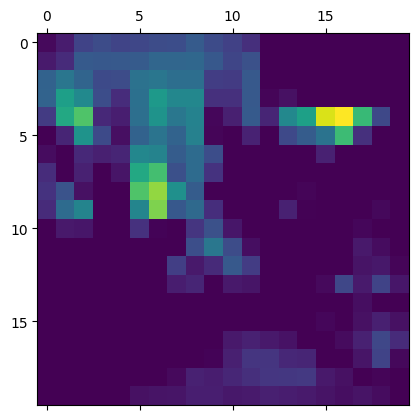

In [17]:
# Prepare image
img_array = get_img_array(img_path=MY_IMG_PATH)

# Print what the top predicted class is
preds = model.predict(img_array)
pred_class = np.argmax(preds)
pred_prob = np.max(preds)
#print(f"Predicted class: {pred_label} \n Probability: {pred_prob} \n Actual Class: {lesion_type_dict[label_abbreviation]}")
print(f"Predicted class: {pred_class} \n Probability: {pred_prob}")

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
)

# Display heatmap
plt.matshow(heatmap)
plt.show()

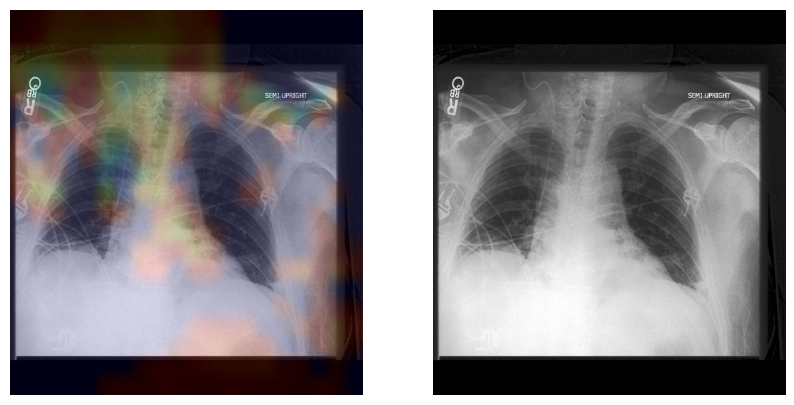

In [23]:
# We load the original image
img = convert_image_to_array(path=MY_IMG_PATH, target_height=TARGET_HEIGHT, target_width=TARGET_WIDTH)
img = np.uint8(255. * img)

# We rescale heatmap to a range 0-255
heatmap = np.uint8(255. * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.2 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
save_path = "heatmap.jpg"
superimposed_img.save(save_path)

# Display Grad CAM along with original image
fig, axs = plt.subplots(1, 2, figsize = (10, 5))

axs[0].imshow(np.asarray(Image.open(save_path)))
axs[0].axis('off')
axs[0].set_aspect('auto')
axs[1].imshow(np.asarray(img))
axs[1].axis('off')
axs[1].set_aspect('auto')

plt.show() 